In [5]:
!pip install pyspark

In [0]:
%matplotlib inline
import pyspark
import matplotlib.pyplot as plt

from pyspark.sql.types import StructType,IntegerType, StructField, FloatType, DecimalType
from pyspark.sql.functions import stddev
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql import Row

import numpy as np
from math import sqrt


In [0]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL") \
    .getOrCreate()

In [50]:
df =  spark.read.option("sep", "\t").csv("sunspots.txt")

df = df.withColumn('Sunspot', df['_c1'].cast(FloatType()))
df = df.withColumn('Index', df['_c0'].cast(IntegerType()))



df.head()
df.drop("_c0","_c1")

DataFrame[Sunspot: float, Index: int]

**Creating a Window**

In [0]:
from pyspark.sql import Window
import pyspark.sql.functions as func
func.Column
windowSpec = Window\
            .orderBy(df['Index'])\
            .rowsBetween(-5,4)

In [0]:
#Calculating rolling means

rollingMean = ((func.avg(df['Sunspot']).over(windowSpec)))
finalDF = df.select(df['Index'], df['Sunspot'], rollingMean.alias("Rolling Average"))

In [0]:
finalDF = finalDF.withColumn("residual", finalDF["Sunspot"] - finalDF["Rolling Average"])
dfPandas= finalDF.toPandas()
stdRes = dfPandas.loc[:, 'residual'].std()


In [0]:
sigma = 3.0
anamolyDetector = finalDF.filter((finalDF['Sunspot'] > finalDF['Rolling Average'] + (sigma * stdRes))
                 |(finalDF['Sunspot'] < finalDF['Rolling Average'] - (sigma * stdRes)))


**Plot of Anomaly Detector**

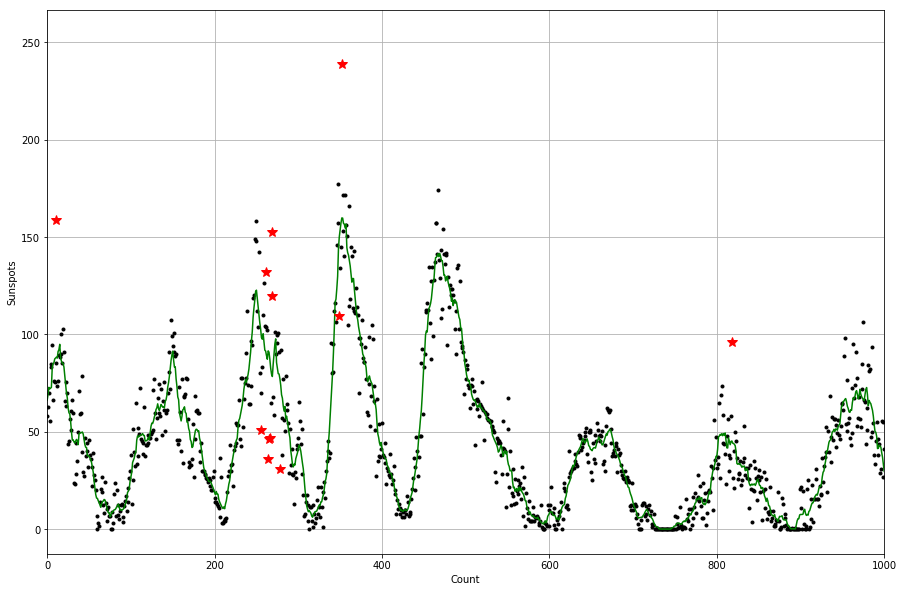

In [55]:
anamolyPandas = anamolyDetector.toPandas()

plt.figure(figsize=(15, 10))
plt.plot(dfPandas['Index'], dfPandas['Sunspot'], "k.")
plt.plot(dfPandas['Index'], dfPandas['Rolling Average'], color = 'green')

plt.plot(anamolyPandas['Index'], anamolyPandas['Sunspot'], "r*", markersize=10)
plt.xlim(0, 1000)

plt.xlabel("Count")
plt.ylabel("Sunspots")
plt.grid()
plt.show()